# 06. Random Forest Modeling
___


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, roc_curve, roc_auc_score

from sklearn.model_selection import GridSearchCV




___


Introduction


In this notebook, I will trying ensemble learning. RandomForest is a model that will use multiple decision trees to see if we can correctly classify our target variable and predict the classes of new datapoints.
I will follow a similar process to notebook 04, where i create a baseline model, a model picked from a gridsearch and a model picked from a gridsearch which uses SMOTE.


___


I will train the model with a portion of the dataset and then compare the outputs with my test set. 


In [2]:
heart22 = pd.read_csv('~/Desktop/capstone-project-Tasnimacj/data/cleaned_data/heart22_preprocessed.csv',index_col=0)

In [3]:
y = heart22['HadAngina'] # Target Variable
X = heart22.drop('HadAngina', axis=1) 

In [4]:
print('Shape of y:', y.shape)
print('Shape of X:', X.shape)

Shape of y: (246013,)
Shape of X: (246013, 41)


In [5]:
#1st split

X_rem, X_test, y_rem, y_test = train_test_split(X, y, test_size=0.2, random_state=25, stratify=y)

print(f'The remainder set has {len(X_rem)} data points.')
print(f'The test set has {len(X_test)} data points.')

The remainder set has 196810 data points.
The test set has 49203 data points.


___

### 1 Baseline Random Forest


The first classifier model will take only the default settings.

In [6]:

random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_rem, y_rem)


RandomForestClassifier()

In [45]:
print(f'Accuracy on remainder set: {random_forest_model.score(X_rem, y_rem)}')
print(f'Accuracy on test set: {random_forest_model.score(X_test, y_test)}')


Accuracy on remainder set: 0.9999237843605507
Accuracy on test set: 0.943946507326789


The model is highly confident in its predictions. Although, we can see a slight overfitting on our remainder set. 

In [46]:
y_test_pred = random_forest_model.predict(X_test)

conmat = pd.DataFrame(
    data = confusion_matrix(y_test, y_test_pred),
    index = ['true 0', 'true 1'],
    columns = ['predicted 0', 'predicted 1']
)
display(conmat)

print(f'Recall score: {recall_score(y_test, y_test_pred)*100:0.2f}%')
print(f'Precision score: {precision_score(y_test, y_test_pred)*100:0.2f}%')
print(f'F1 score: {f1_score(y_test, y_test_pred)*100:0.2f}%')

,predicted 0,predicted 1
true 0,45766,446
true 1,2312,679


Recall score: 22.70%
Precision score: 60.36%
F1 score: 32.99%


In [47]:
base_r = round(recall_score(y_test, y_test_pred)*100, 2)
base_p = round(precision_score(y_test, y_test_pred)*100, 2)
base_f1 = round(f1_score(y_test, y_test_pred)*100, 2)
base_a = round(random_forest_model.score(X_test, y_test)*100,2)

We can see that our model only correctly classified 23% of all '1's, and only 60% were right. 


In [48]:
from sklearn.metrics import roc_curve, roc_auc_score 
y_proba_base = random_forest_model.predict_proba(X_test)[:,1]

fprs_base, tprs_base, thresholds_base = roc_curve(y_test, y_proba_base)
roc_auc_base = roc_auc_score(y_test, y_proba_base)

___

### 2 Tuning Random Forest

In [9]:
from tempfile import mkdtemp
cachedir = mkdtemp()

In [10]:
# gridsearch

pipe = Pipeline([("scaler", StandardScaler()),
                 ("model", RandomForestClassifier())], memory=cachedir)
                 
param =  {'scaler': [ StandardScaler()],
          'model__max_depth' : [4, 8, 12],
          'model__n_estimators' : [64, 128] }


grid = GridSearchCV(estimator=pipe,param_grid=param, cv=5,verbose=1,refit=True)

In [11]:
fittedgrid = grid.fit(X_rem,y_rem)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [12]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'scaler', 'model', 'scaler__copy', 'scaler__with_mean', 'scaler__with_std', 'model__bootstrap', 'model__ccp_alpha', 'model__class_weight', 'model__criterion', 'model__max_depth', 'model__max_features', 'model__max_leaf_nodes', 'model__max_samples', 'model__min_impurity_decrease', 'model__min_impurity_split', 'model__min_samples_leaf', 'model__min_samples_split', 'model__min_weight_fraction_leaf', 'model__n_estimators', 'model__n_jobs', 'model__oob_score', 'model__random_state', 'model__verbose', 'model__warm_start'])

In [13]:
fittedgrid.best_params_

{'model__max_depth': 12,
 'model__n_estimators': 128,
 'scaler': StandardScaler()}

Model Interpretation

<Axes: >

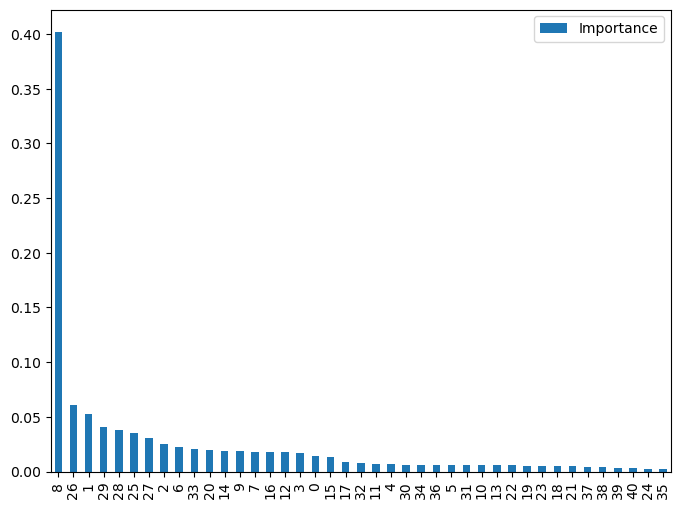

In [31]:

feat_importances = pd.DataFrame({'Feature': X_rem.columns, 'Importance': fittedgrid.best_estimator_.named_steps["model"].feature_importances_,})
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

In [50]:
feat_importances.head()

,Feature,Importance
8,HadHeartAttack,0.402279
26,AgeCategory,0.060710
1,GeneralHealth,0.052619
29,BMI,0.040533
28,WeightInKilograms,0.037741


In [49]:
feat_importances.tail()

,Feature,Importance
38,RaceEthnicity_Hispanic,0.003913
39,RaceEthnicity_Multiracial,0.002898
40,RaceEthnicity_Other race only,0.002854
24,ECigaretteUsage,0.002613
35,HighRiskLastYear,0.002420


The model places HadHeartAttack as a very important feature but considers HighRiskLastYear low importance. It takes an average feature importance of each tree in the model.

Model Evaluation

In [38]:
print(f"Best accuracy on the remainder set: {fittedgrid.score(X_rem, y_rem)}")
print(f"Best accuracy on the test set: {fittedgrid.score(X_test, y_test)}")


y_test_pred = fittedgrid.predict(X_test)


conmat = pd.DataFrame(
    data = confusion_matrix(y_test, y_test_pred),
    index = ['true 0', 'true 1'],
    columns = ['predicted 0', 'predicted 1']
)
display(conmat)

print(f'Recall score: {recall_score(y_test, y_test_pred)*100:0.2f}%')
print(f'Precision score: {precision_score(y_test, y_test_pred)*100:0.2f}%')
print(f'F1 score: {f1_score(y_test, y_test_pred)*100:0.2f}%')

Best accuracy on the remainder set: 0.9568060566028149
Best accuracy on the test set: 0.9442107188586062


,predicted 0,predicted 1
true 0,45873,339
true 1,2406,585


Recall score: 19.56%
Precision score: 63.31%
F1 score: 29.89%


In [39]:
best_r = round(recall_score(y_test, y_test_pred)*100, 2)
best_p = round(precision_score(y_test, y_test_pred)*100, 2)
best_f1 = round(f1_score(y_test, y_test_pred)*100, 2)
best_a = round(fittedgrid.score(X_test, y_test)*100,2)

Our model has a lower F1 score thanks to the drop in recall. This is not what I was hoping for. Our precision has increased but that is irrelevant if we are predicting most of our data wrong.

In [51]:
y_proba_rf = fittedgrid.best_estimator_.predict_proba(X_test)[:,1]

fprs_rf, tprs_rf, thresholds_rf = roc_curve(y_test, y_proba_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)


___

### 3 SMOTE

In [15]:
# SMOTE
from imblearn.over_sampling import SMOTE

X_rem_sm, y_rem_sm = SMOTE(random_state=1).fit_resample(X_rem, y_rem)

In [16]:

print('Original class distribution')
print((y_rem).value_counts().sort_index(),'\n')

print('Resampled class distribution')
print((y_rem_sm).value_counts().sort_index())

Original class distribution
HadAngina
0    184848
1     11962
Name: count, dtype: int64 

Resampled class distribution
HadAngina
0    184848
1    184848
Name: count, dtype: int64


Upscale our datapoints so that they are equally distributed.

In [17]:
# gridsearch

pipe = Pipeline([("scaler", StandardScaler()),
                 ("model", RandomForestClassifier())], memory=cachedir)
                 
param =  {'scaler': [ StandardScaler()],
          'model__max_depth' : [4, 8, 12],
          'model__n_estimators' : [64, 128] }


grid = GridSearchCV(estimator=pipe,param_grid=param, cv=5,verbose=1,refit=True)

In [18]:
fittedgrid_sm = grid.fit(X_rem_sm,y_rem_sm)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [19]:
fittedgrid_sm.best_params_

{'model__max_depth': 12,
 'model__n_estimators': 128,
 'scaler': StandardScaler()}

In [20]:
fittedgrid_sm.best_estimator_

Pipeline(memory='/var/folders/r3/bz5mjtds4dvdw0hskxwvs9vc0000gp/T/tmpyvthk1ol',
         steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=12, n_estimators=128))])

Model Interpretation

<Axes: >

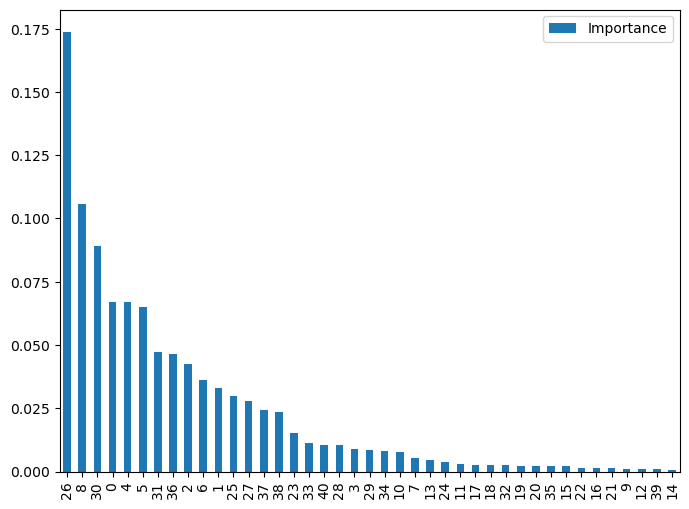

In [29]:

feat_importances_sm = pd.DataFrame({'Feature': X_rem_sm.columns, 'Importance': fittedgrid_sm.best_estimator_.named_steps["model"].feature_importances_,})
feat_importances_sm.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances_sm.plot(kind='bar', figsize=(8,6))

In [54]:
feat_importances_sm.head()

,Feature,Importance
26,AgeCategory,0.173836
8,HadHeartAttack,0.105537
30,AlcoholDrinkers,0.089224
0,Female,0.067024
4,LastCheckupTime,0.066795


In [55]:
feat_importances_sm.tail()

,Feature,Importance
21,DifficultyDressingBathing,0.001332
9,HadStroke,0.001042
12,HadCOPD,0.000983
39,RaceEthnicity_Multiracial,0.000817
14,HadKidneyDisease,0.000629


The feature that is considered the most important is AgeCategory but only has an average importance of 0.17. The least important feature on average is whether a person has difficulty dressing or bathing.

Model Evaluation

In [22]:
print(f"Best accuracy on the remainder set: {fittedgrid_sm.score(X_rem, y_rem)}")
print(f"Best accuracy on the test set: {fittedgrid_sm.score(X_test, y_test)}")


y_test_pred = fittedgrid_sm.predict(X_test)


conmat = pd.DataFrame(
    data = confusion_matrix(y_test, y_test_pred),
    index = ['true 0', 'true 1'],
    columns = ['predicted 0', 'predicted 1']
)
display(conmat)

print(f'Recall score: {recall_score(y_test, y_test_pred)*100:0.2f}%')
print(f'Precision score: {precision_score(y_test, y_test_pred)*100:0.2f}%')
print(f'F1 score: {f1_score(y_test, y_test_pred)*100:0.2f}%')

Best accuracy on the remainder set: 0.8267618515319344
Best accuracy on the test set: 0.8162307176391683


,predicted 0,predicted 1
true 0,38182,8030
true 1,1012,1979


Recall score: 66.17%
Precision score: 19.77%
F1 score: 30.45%


In [37]:
best_sm_r = round(recall_score(y_test, y_test_pred)*100, 2)
best_sm_p = round(precision_score(y_test, y_test_pred)*100, 2)
best_sm_f1 = round(f1_score(y_test, y_test_pred)*100, 2)
best_sm_a = round(fittedgrid_sm.score(X_test, y_test)*100,2)

Our accuracy has dropped but our recall is very good. After SMOTE, we can now correctly predict 66% of our test data. We have a precision of 20% so we are misclassifing a lot of datapoints as having Angina when they do not. As we only want to use a model as flagging system for health advice rather than treatment, having a lot of false positives would be better than false negatives. There would be fewer repercussions.

In [56]:
y_proba_sm = fittedgrid_sm.best_estimator_.predict_proba(X_test)[:,1]

fprs_sm, tprs_sm, thresholds_sm = roc_curve(y_test, y_proba_sm)
roc_auc_sm = roc_auc_score(y_test, y_proba_sm)


___


Conclusion

In [59]:
data = {'F1 score' :[base_f1, best_f1, best_sm_f1],
       'Recall score':[base_r, best_r, best_sm_r], 
       'Precision score':[base_p, best_p, best_sm_p],
       'Accuracy':[base_a, best_a, best_sm_a]}


scores = pd.DataFrame(
    data = data,
    index = ['Base RF', 'Best RF', 'Best SMOTE RF'],
    columns = ['F1 score','Recall score', 'Precision score', 'Accuracy']
)

In [60]:
scores

,F1 score,Recall score,Precision score,Accuracy
Base RF,32.99,22.70,60.36,94.39
Best RF,29.89,19.56,63.31,94.42
Best SMOTE RF,30.45,66.17,19.77,81.62


With our Random Forest model, we can see that even if we had a low recall, we would have a high percentage of correct predictions. After exposing our model to more data points using SMOTE, we were able to greatly improve our recall score. 
We can plot an ROC to see our True positive vs False positive rates.

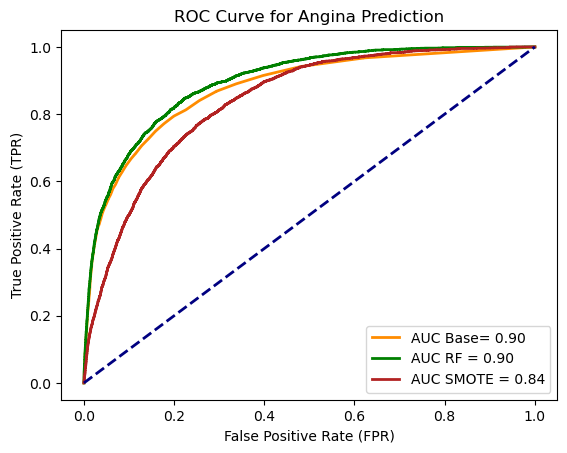

Area under curve (AUC) Base:0.8952475519984461
Area under curve (AUC) RF:0.8952475519984461
Area under curve (AUC) SMOTE:0.8382557978618622



In [57]:
plt.figure()

plt.plot(fprs_base, tprs_base, color='darkorange',
         lw=2, label='AUC Base= %0.2f' % roc_auc)
plt.plot(fprs_rf, tprs_rf, color='green',
         lw=2, label='AUC RF = %0.2f' % roc_auc_rf)
plt.plot(fprs_sm, tprs_sm, color='firebrick',
         lw=2, label='AUC SMOTE = %0.2f' % roc_auc_sm)

         
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Angina Prediction')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC) Base:{roc_auc}')
print(f'Area under curve (AUC) RF:{roc_auc_rf}')
print(f'Area under curve (AUC) SMOTE:{roc_auc_sm}')
print()

We can see that even though the best RandomForest model with SMOTE performed better in terms of recall, its ROC is slightly worse compared to the other two models. This means that we would have to settle for a lower TPR if we want to minimise the FPR. 

Despite this, I will save the fittedgrid_sm model as my final model and end my modeling process now.

Next notebook, I will present my findings and investigate why the models may have had a hard time predicting whether a person had Angina.

In [42]:
scores.to_csv('~/Desktop/capstone-project-Tasnimacj/data/cleaned_data/scores_rf.csv')

In [61]:
import joblib

# Saving our best model 
joblib.dump(fittedgrid_sm, '../model/fitted_RF_sm.pkl')


['../model/fitted_RF_sm.pkl']